In [ ]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.layers import Conv1D , GlobalMaxPooling1D,MaxPooling1D,Conv2D
from keras.callbacks import ModelCheckpoint

In [ ]:
num_classes = 3

embed_num_dims = 200
max_seq_len = 1000


class_names = ['Positive', 'Negative','Neutral']

In [ ]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
      df.apply(np.random.shuffle, axis=axis)
    return df

In [ ]:
data=pd.read_excel('/content/daraz.xlsx')

In [ ]:
print(data.columns)

Index(['Sl', 'Text', 'Categore', 'Polarity'], dtype='object')


In [ ]:
data.isnull().values.any()

True

In [ ]:
data.dropna(subset = ["Text","Polarity"], inplace =True )

In [ ]:
data.isnull().values.any()

True

<Axes: xlabel='Polarity', ylabel='count'>

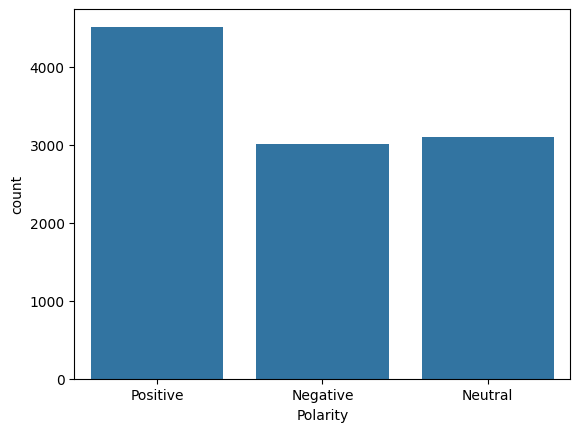

In [ ]:
import seaborn as sns
sns.countplot(x='Polarity', data=data)

In [ ]:
data.sort_values(by='Polarity', axis=0, inplace=True)

data.set_index(keys=['Polarity'], drop=False,inplace=True)
Categorys=data['Polarity'].unique().tolist()

In [ ]:
positives = shuffle(data.loc[data.Polarity=='Positive'])
negatives = shuffle(data.loc[data.Polarity=='Negative'])
neutrals = shuffle(data.loc[data.Polarity=='Neutral'])

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10

In [ ]:
positives_train = positives.iloc[0:int(positives.shape[0]*1)]
positives_test = positives.iloc[0:int(positives.shape[0]*1)]

negatives_train = negatives.iloc[0:int(negatives.shape[0]*1)]
negatives_test = negatives.iloc[0:int(negatives.shape[0]*1)]

neutrals_train = neutrals.iloc[0:int(neutrals.shape[0]*1)]
neutrals_test = neutrals.iloc[0:int(neutrals.shape[0]*1)]

data_train = pd.concat([positives_train, negatives_train, neutrals_train])
data_test = pd.concat([positives_test, negatives_test, neutrals_test])

print(data_train.shape)
print(data_test.shape)

(10637, 4)
(10637, 4)


In [ ]:
X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Polarity
y_test = data_test.Polarity

data = pd.concat([data_train, data_test], ignore_index=True)

print(data['Polarity'].value_counts())
data.head(10)

Polarity
Positive    9032
Neutral     6212
Negative    6030
Name: count, dtype: int64


,Sl,Text,Categore,Polarity
0,4301,৪৮৫ টাকায় দারুন প্রোডাক্ট।,phone,Positive
1,2027,প্যাকেজিং খুব ভালো ছিল। খুব সুন্দর ভাবে ও দ্রু...,phone,Positive
2,2964,২৯ টাকার হিসাবে পেঁয়াজ সাইজে বেশ বড়। ভালো কোয়া...,phone,Positive
3,4355,গত কাল প্রোডাক্ট পেয়েছি। ৬বছরের বাচ্চার জন্য ন...,phone,Positive
4,4005,আলহামদুলিল্লাহ যেমনটা চেয়েছে তেমন পেয়েছি।বই হও...,phone,Positive
5,3234,এটা ভালো যেমন অডাড় করেছি তেমন পেয়েছি খুব ভালো ...,phone,Positive
6,3180,প্রোডাক্টটি খুবই সুন্দর হয়েছে সেলসম্যান অনেক ...,phone,Positive
7,4400,ক্যাশ ব্যাক আর ভাউচারে মাত্র ৩১৩ টাকায় পেয়েছি।...,saree,Positive
8,3788,"সব কিছুই ঠিকঠাক মত পেয়েছি,,মিস্তিরি পাইলে লাগি...",phone,Positive
9,446,"ব্যাগের আন্টাগুলো স্টিল হলে ভাল হতো, \nআপনারা ...",phone,Positive


In [ ]:
print(data.dtypes)


Sl           int64
Text        object
Categore    object
Polarity    object
dtype: object


In [ ]:
print(data_train.Polarity.value_counts())
print(data_test.Polarity.value_counts())

Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64
Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import re
from nltk.tokenize import word_tokenize

def remove_emojis(text):
    # Emoji pattern: Matches any unicode emoji
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z0-9]+', flags=re.I)
    text = english_pattern.sub(r'', text)
    text = emoji_pattern.sub(r'', text)
    return text

def clean_text(data):
    # Check if data is None or NaN, and convert to an empty string
    if data is None or pd.isnull(data):
        data = ''

    # Convert data to string if it's not already
    if not isinstance(data, str):
        data = str(data)

    # Text cleaning operations
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = remove_emojis(data)
    data_tokens = word_tokenize(data)
    cleaned_data = ' '.join(data_tokens)

    return cleaned_data
def remove_punctuations(my_str):
    # Define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # Display the unpunctuated string
    return no_punct

def preprocessing(text):
    # Preprocess text
    text = clean_text(text)
    text = remove_punctuations(text)
    return text

texts = [clean_text(text) for text in data.Text]
texts_train = [clean_text(text) for text in X_train]
texts_test = [clean_text(text) for text in X_test]

print(texts_train[5])

এটা ভালো যেমন অডাড় করেছি তেমন পেয়েছি খুব ভালো সবাই কিনবেন


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)



index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 15255


In [ ]:
print("Sentence :--> \n")
print(texts_train[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequence_train[2])+"\n")

Sentence :--> 

২৯ টাকার হিসাবে পেঁয়াজ সাইজে বেশ বড়। ভালো কোয়ালিটির ই পেয়েছি। ৩ বার অর্ডার করেছি। পরের দিনই ডেলিভারি পেয়েছি। ডেলিভারি পারসন খুবই হেল্পফুল ছিল।

Sentence Tokenized and Converted into Sequence :--> 

[1746, 223, 324, 1579, 1391, 157, 1447, 1, 692, 122, 14, 176, 268, 26, 614, 1448, 2711, 17, 14, 17, 8030, 27, 2090, 69]



In [ ]:
!pip install Keras-Preprocessing

In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  597,  238,  193],
       [   0,    0,    0, ...,   10, 1953, 2710],
       [   0,    0,    0, ...,   27, 2090,   69],
       ...,
       [   0,    0,    0, ...,  235, 1087, 1386],
       [   0,    0,    0, ..., 1425,  490,   39],
       [   0,    0,    0, ...,  748,  207,  232]], dtype=int32)

In [ ]:
print(data_train.columns)


Index(['Sl', 'Text', 'Categore', 'Polarity'], dtype='object')


In [ ]:
encoding = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

y_train = [encoding[x] for x in data_train.Polarity]
y_test = [encoding[x] for x in data_test.Polarity]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
import urllib.request
import zipfile
import os

GLOVE_DIM = 200
fname = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'

# Debugging output
print('Checking if file exists:', fname)

# Check if the file exists, if not, download and extract it
if not os.path.isfile(fname):
    print('Downloading word vectors...')
    try:
        # Try downloading from a different URL
        urllib.request.urlretrieve('http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip', 'glove.twitter.27B.zip')
        print('Unzipping...')
        with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
            zip_ref.extractall('')
        print('Done.')

        # Remove the downloaded zip file
        os.remove('glove.twitter.27B.zip')

    except Exception as e:
        print('Error occurred while downloading:', e)



Checking if file exists: glove.twitter.27B.200d.txt


In [ ]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

NB_WORDS = vocab_size
MAX_LEN = max_seq_len

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length = max_seq_len,
                         weights = [emb_matrix],
                         trainable=False)

lstm_size = 128

In [ ]:
model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         3051200   
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 200)         0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 1000, 64)          38464     
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 256)          49408     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 256)          0

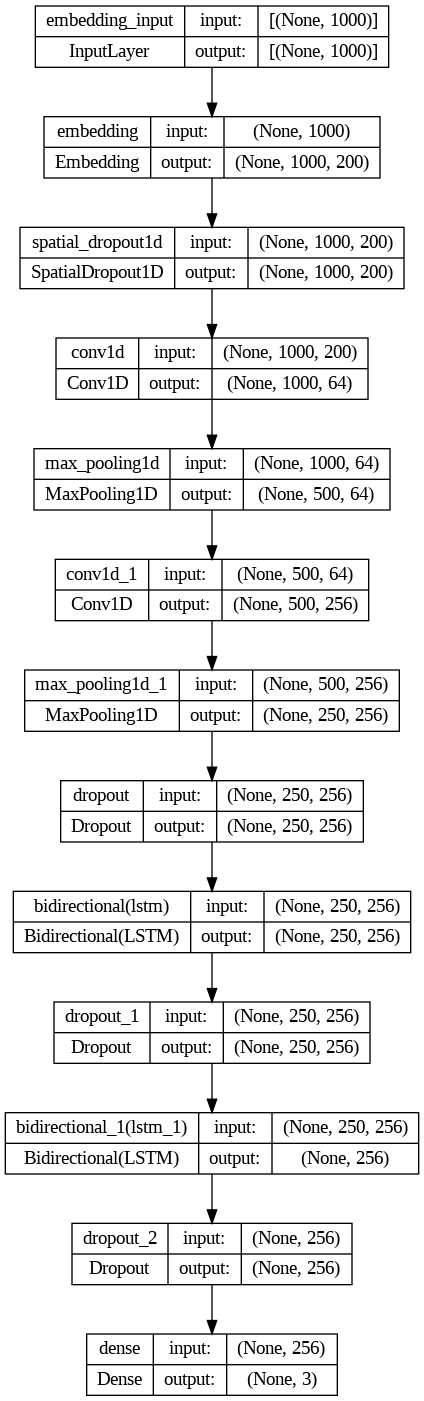

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(10637, 1000)
(10637, 3)
(10637, 1000)
(10637, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/70
42/42 [==============================] - 31s 341ms/step - loss: 1.0110 - accuracy: 0.4864 - val_loss: 0.9119 - val_accuracy: 0.5593
Epoch 2/70
42/42 [==============================] - 13s 305ms/step - loss: 0.8840 - accuracy: 0.5915 - val_loss: 0.8058 - val_accuracy: 0.6308
Epoch 3/70
42/42 [==============================] - 13s 305ms/step - loss: 0.8128 - accuracy: 0.6370 - val_loss: 0.7810 - val_accuracy: 0.6493
Epoch 4/70
42/42 [==============================] - 13s 306ms/step - loss: 0.7851 - accuracy: 0.6509 - val_loss: 0.7275 - val_accuracy: 0.6837
Epoch 5/70
42/42 [==============================] - 13s 306ms/step - loss: 0.7639 - accuracy: 0.6578 - val_loss: 0.6952 - val_accuracy: 0.6960
Epoch 6/70
42/42 [==============================] - 10s 248ms/step - loss: 0.7311 - accuracy: 0.6706 - val_loss: 0.6804 - val_accuracy: 0.7001
Epoch 7/70
42/42 [==============================] - 11s 255ms/step - loss: 0.7166 - accuracy: 0.6820 - val_loss: 0.6370 - val_accuracy: 0.7187

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

931.23


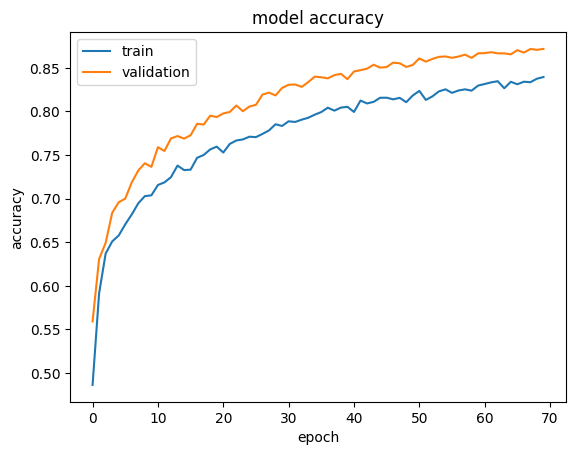

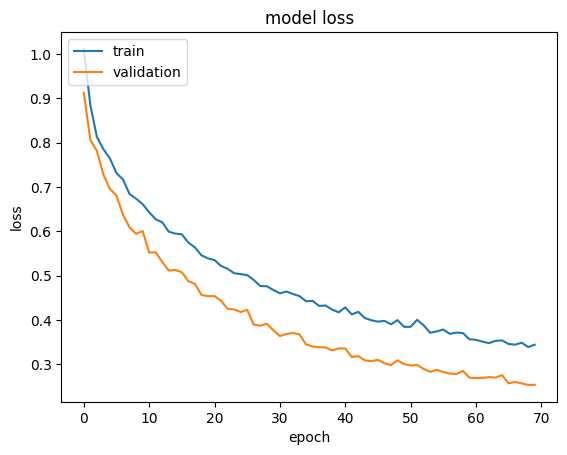

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

333/333 [==============================] - 8s 18ms/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='weighted'))

(0.8717683557394003, 0.8717683557394003, 0.8717683557394003, None)
(0.8745597335841987, 0.8741435730112682, 0.8700815488848606, None)
(0.8838114218544497, 0.8717683557394003, 0.873903814708384, None)



F1 Score: 87.18


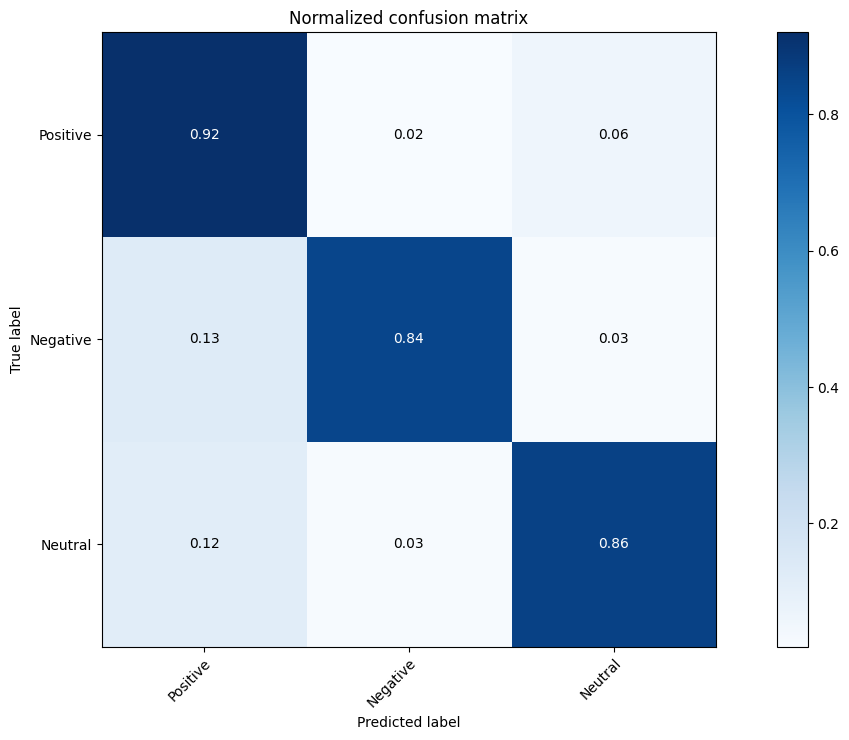

Message: প্রোডাক্টটি খুবই সুন্দর হয়েছে সেলসম্যান অনেক ভালো ছিল
Predicted: Positive


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Polarity, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Polarity, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Polarity, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Polarity, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Polarity, predictions, target_names=class_names))


Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.87
Macro Recall: 0.87
Macro F1-score: 0.87

Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.87

Classification Report

              precision    recall  f1-score   support

    Positive       0.75      0.92      0.83      3015
    Negative       0.94      0.84      0.89      3106
     Neutral       0.94      0.86      0.90      4516

    accuracy                           0.87     10637
   macro avg       0.87      0.87      0.87     10637
weighted avg       0.88      0.87      0.87     10637



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Polarity, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


Sensitivity :  0.8725613593455003
Specificity :  0.9779768570362075
false positive rate :  0.02202314296379246
false negative rate :  0.1274386406544997
Negative Predictive Value :  0.8661157024793389
False Discovery rate :  0.020833333333333332


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Polarity, predictions))

333/333 [==============================] - 7s 22ms/step
Mean Absolute Error: 0.10541719
333/333 [==============================] - 8s 23ms/step
Mean Squared Error: 0.05022877
333/333 [==============================] - 7s 21ms/step
Root Mean Squared Error: 0.22411776
Cohen_Kappa_Score: 0.8055132801764527


In [ ]:
import time

message = ['ব্যবহার করা হয়েছে ভালো ফলাফল পেয়েছি আর একটা নেব ইনশাআল্লাহ']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 165ms/step
Message: ['ব্যবহার করা হয়েছে ভালো ফলাফল পেয়েছি আর একটা নেব ইনশাআল্লাহ']
predicted: Neutral (0.22 seconds)


In [ ]:
import time

message = ["ফালতু প্রোডাক্ট দিছে কোন কাজে আসে না 😈😈😈"]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 28ms/step
Message: ['ফালতু প্রোডাক্ট দিছে কোন কাজে আসে না 😈😈😈']
predicted: Negative (0.07 seconds)


In [ ]:
import time

message = ["পেকেজিং মুটামুটি ঠিক আছে।"]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 28ms/step
Message: ['পেকেজিং মুটামুটি ঠিক আছে।']
predicted: Negative (0.08 seconds)
